In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
from PIL import Image
import yaml
import pickle
from utils import *
from helpers import *

import pdb
from tqdm import tqdm

from proSVD import proSVD
from dlclive import DLCLive, Processor

In [45]:
config_file = "octo-17"
with open(f'configs/{config_file}.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
IS_METADATA_PRESENT = (config['path']['xls'] is not None)
files_info = None
filenames = None

fps = config['info']['fps']

root_dir = config['path']['root']
video_dir = f"{root_dir}/{config['path']['video']}"

if IS_METADATA_PRESENT:
    xls_path = f"{root_dir}/{config['path']['xls']}"
    files_info = read_octopus_xlsx(xls_path)
    # files_info = files_info[files_info['Stim Method'] == 'Mechanical']
    filenames = files_info["File Name"].to_list()
else:
    filenames = [os.path.splitext(file)[0] for file in os.listdir(video_dir)]

###

working_dir = f"{root_dir}/{config['path']['working']}" # to save processed data and figures

model_path = f"{root_dir}/{config['path']['model']}"

dlc_live = DLCLive(
    model_path,
    processor=Processor(),
    pcutoff=0.2,
    resize=1)

PROSVD_K = 4 # no. of dims to reduce to

TIME_MARGIN = (-120, 180) # to trim videos
total_f = TIME_MARGIN[1] - TIME_MARGIN[0]

init_frame_crop = 10 # No of initial frames used to set cropping info
init_frame_prosvd = 90 # No of initial frames used to initialize proSVD
init_frame = init_frame_crop + init_frame_prosvd


DEV_MODE = False
if DEV_MODE:
    files_info = files_info.iloc[[0,3,13,14,15,16]] #[3:4]
    filenames = files_info["File Name"].to_list()

print(f"Processing {len(filenames)} videos from {video_dir}")
if len(filenames) < 4:
    print('\t', end='')
    print(*filenames, sep="\n\t")

Processing 148 videos from /home/sachinks/Code/MyProjects/OctopusVideos/videos


In [46]:
def get_fig_dir(filename):
    figs_dir = f"{working_dir}/figs"
    os.makedirs(figs_dir, exist_ok=True)
    return figs_dir

def get_data_dir(filename=None):
    if filename is None:
        data_dir = f"{working_dir}"
    else:
        data_dir = f"{working_dir}/data/{filename}"
    os.makedirs(data_dir, exist_ok=True)
    return data_dir

def is_badpose(likely, threshold=0.8):
    return np.mean(likely) < threshold

def calculate_nancount(data):
    nan_count = np.sum(np.isnan(data))
    return 100*nan_count/data.size

def fill_nan_linear_interpolation_axis(arr, axis):
    def fill_nan_linear_interpolation(row):
        nan_mask = np.isnan(row)
        indices = np.arange(len(row))
        row[nan_mask] = np.interp(indices[nan_mask], indices[~nan_mask], row[~nan_mask])
        return row
    
    return np.apply_along_axis(fill_nan_linear_interpolation, axis, arr)

In [47]:
for video_idx in tqdm(range(len(files_info))):
    row = files_info.iloc[video_idx]
    md = load_metadata_new(row, time_margin = TIME_MARGIN)

    start_f, end_f = md[0], md[1]
    total_f = end_f - start_f

    video_filename = filenames[video_idx]

    video = None

    try:
        video = load_video(video_dir, video_filename)
        video.set(cv2.CAP_PROP_POS_FRAMES, start_f)
    except:
        continue

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    crop_box = np.zeros(4, int)

    index = -1

    frames = []  # for proSVD initialization
    dm = DataManager()
    pro = None

    while video.isOpened():
        index += 1
        if index >= total_f:
            break

        ret, frame = video.read()
        if not ret:
            break

        # Cropping starts
        if index < init_frame_crop:
            crop_box += detect_crop_box_wrapper(dlc_live, frame, index, margin=max(40, int(frame.size//(3*5*1e4))))
            continue

        if index == init_frame_crop:
            crop_box //= init_frame_crop

        frame2 = frame[crop_box[0]:crop_box[1],crop_box[2]:crop_box[3],:]

        # Cropping ends

        # pose = detect_pose(dlc_live, frame, index)

        frame2 = rgb_to_grayscale(frame2)
        frame2 = downsample_image(frame2)

        # save the cropped frame for checking if cropping done correctly
        if index == init_frame_crop:
            crop_dir = f'{figs_dir}/cropped'
            os.makedirs(crop_dir, exist_ok=True)
            im = Image.fromarray(frame2)
            im.save(f'{crop_dir}/{video_filename}.png')

        frame2 = frame2.flatten()

        if index < init_frame:
            frames.append(frame2)
            continue

        # proSVD starts

        if index == init_frame:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)
            del frames

        # if is_badpose(pose[...,-1]):
        #     dm.add('Q', None)
        #     continue

        pro.preupdate()
        pro.updateSVD(frame2[:, None])
        pro.postupdate()

        # pro_coordi = frame2 @ pro.Q
        dm.add('Q', pro.Q)

    video.release()

    dm.to_numpy()
    np.save(f'{data_dir}/Q.npy', dm.get('Q'))

 37%|███▋      | 55/148 [03:30<13:54,  8.98s/it]

File not found: cord_pinch_220303_120622


100%|██████████| 148/148 [10:51<00:00,  4.40s/it]


In [52]:
display(files_info['Stimulation Class'].value_counts().sort_index())
display(files_info['Classification'].value_counts())

Cord Electrical        14
Cord Mechanical        19
Distal Electrical      26
Distal Mechanical      45
Proximal Electrical    16
Proximal Mechanical    28
Name: Stimulation Class, dtype: int64

1    62
2    45
0    41
Name: Classification, dtype: int64

In [49]:
# Post processing!

stim_class_list =  ['Cord Electrical', 'Distal Electrical', 'Proximal Electrical', 'Cord Mechanical', 'Distal Mechanical', 'Proximal Mechanical']
stim_count = len(stim_class_list)

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

err_log = {
    'poor_pose': [],
    'file_missing': []
}

columns = ['filename', 'dQ']
df = pd.DataFrame(columns=columns)

for video_idx in tqdm(range(len(filenames))):
    video_filename = filenames[video_idx]

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")

    total_frames = Q_full.shape[0]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    move_idx = int(row['Classification'])
    stim_idx = stim_class_list.index(stim_class)

    data = {}
    data['filename'] = video_filename
    data['dQ'] = Q_norm_diff

    df = df.append(data, ignore_index=True)

    del Q_full
    del Q_diff
    del Q_norm_diff

df.columns = pd.MultiIndex.from_tuples([
    ('metadata', 'filename'),
    ('features', 'dQ')
])

data_dir = get_data_dir()

with open(f'{data_dir}/proSVD_features.pkl', 'wb') as f:
    pickle.dump(df, f)

100%|██████████| 148/148 [00:20<00:00,  7.25it/s]


In [50]:
with open(f'{data_dir}/proSVD_features.pkl', 'rb') as f:
    df_features = pickle.load(f)
print(df_features[[('features', 'dQ')]].iloc[0][0].shape)
df_features.head(3)

(200, 4)


,metadata,features
,filename,dQ
0,elec_right_cord_100Hz_5mA_220616_131634_000,"[[0.0, 0.0, 0.0, 0.0], [0.006909703216576469, ..."
1,proximal_pinch_220616_115258_000,"[[0.0, 0.0, 0.0, 0.0], [0.011314186517125095, ..."
2,proximal_pinch_220616_115654_000,"[[0.0, 0.0, 0.0, 0.0], [0.004426496885623101, ..."


In [41]:
df_features[[('features', 'dQ')]].values.shape

(3, 1)

In [496]:
num_classes = 3

# Load and preprocess the data
with open(f'data/pro_features.pkl', 'rb') as f:
    df_features = pickle.load(f)
X = np.stack(df_features['features'].values, axis=-1).T
X = X.reshape(X.shape[0], -1)
# linear interpolation to fill nan values
X = fill_nan_linear_interpolation_axis(X, axis=1)

y = df_features['labels'].values.astype(int)

(56, 800) (56,)


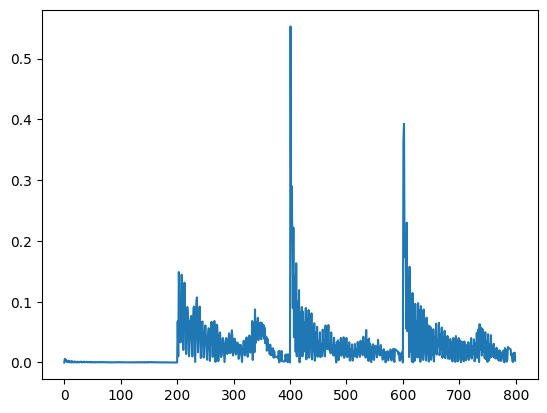

In [497]:
print(X.shape, y.shape)
plt.plot(X[0])

In [489]:
X = df_features['features'].values
N = len(X)
no_f = PROSVD_K-1 # no of features
mean_val = np.zeros((N, no_f))
max_val = np.zeros((N, no_f))

## intervals for computing angle
intv_list = [
    [20, 50], # 1 second immediately following stimulation
    [50, 80], # 1-2 sec
    [80, None] # > 2 sec
]

for i in range(len(X)):
    feat = X[i][:, 1:]
    for j in range(no_f):
        mean_val[i, j] = np.nanmean(feat[:, j])
        max_val[i, j] = np.nanmax(feat[:, j])

# df_final = pd.DataFrame({
#     'Mean val' : mean_val, 
#     'Max val' : max_val})

# df_final.head(3)
all_data = np.concatenate([mean_val, max_val], axis=-1)
all_data.shape

(56, 6)

In [514]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = all_data  # 56 samples with 6 features each

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

In [538]:
import numpy as np
from sklearn.mixture import GaussianMixture

X = reduced_data
n_components_range = range(1, 11)

# Initialize empty lists to store BIC values
bic_values = []

# Fit GMM models for different numbers of components and calculate BIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_values.append(gmm.bic(X))

optimal_n_components_bic = np.argmin(bic_values) + 1

print("Optimal number of components (BIC):", optimal_n_components_bic)


Optimal number of components (BIC): 5


In [535]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score

# Generate sample data for clustering
X = reduced_data
y_true = df_features['labels'].values.astype(int)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Perform Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Evaluate clustering results using various metrics
print("K-means:")
print("Silhouette Score:", silhouette_score(X, kmeans_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, kmeans_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, kmeans_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, kmeans_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, kmeans_labels))

print("\nGMM:")
print("Silhouette Score:", silhouette_score(X, gmm_labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X, gmm_labels))
print("Davies-Bouldin Index:", davies_bouldin_score(X, gmm_labels))
print("Adjusted Rand Index:", adjusted_rand_score(y_true, gmm_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(y_true, gmm_labels))


K-means:
Silhouette Score: 0.4632803515999111
Calinski-Harabasz Index: 65.61641984288012
Davies-Bouldin Index: 0.5967295234930061
Adjusted Rand Index: 0.015101617510598424
Normalized Mutual Information: 0.10246518401600592

GMM:
Silhouette Score: 0.36959343513032783
Calinski-Harabasz Index: 46.648138007748365
Davies-Bouldin Index: 0.7026163011986274
Adjusted Rand Index: -0.0070849279285524055
Normalized Mutual Information: 0.06846880883823021


In [524]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

data = reduced_data

NO_OF_CLUSTERS = 3
GMM = GaussianMixture(n_components = NO_OF_CLUSTERS, random_state=517).fit(data)
cluster = GMM.predict(data)
centroids = GMM.means_

In [525]:
def plot_ellipse(centroids, covariances, ax, color):
    covariance_matrix = covariances
    mean_x, mean_y = centroids

    # Step 1: Eigendecomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 2: Calculate the principal axes and angles
    principal_axes = eigenvectors.T
    angle = -np.arctan2(principal_axes[1, 0], principal_axes[0, 0])

    # Step 3: Choose confidence levels (e.g., 1, 2, and 3 standard deviations)
    confidence_levels = [1, 2, 3]

    # Step 4: Plot the ellipses

    for level in confidence_levels:
        width = 2 * level * np.sqrt(eigenvalues[0])
        height = 2 * level * np.sqrt(eigenvalues[1])
        ellipse = Ellipse(xy=(mean_x, mean_y), width=width, height=height,
         angle=np.degrees(angle), color=color)
        ellipse.set_alpha(0.2)  # Set the ellipse transparency
        ax.add_patch(ellipse)

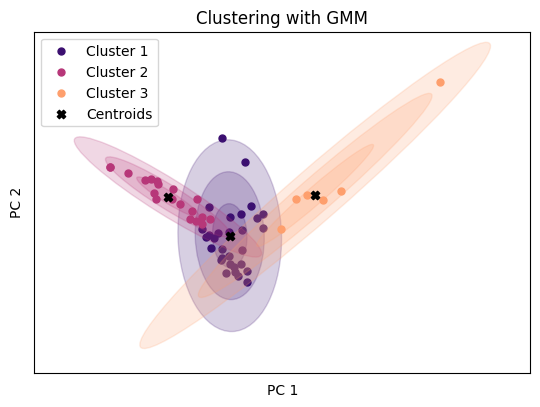

In [529]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=NO_OF_CLUSTERS))

for k in range(NO_OF_CLUSTERS):
    plot_ellipse(centroids[k], GMM.covariances_[k], ax, colors[k])
    plt.scatter(*data[cluster==k, :].T, s=25, color=colors[k], label=f'Cluster {k+1}')

plt.scatter(*centroids.T, marker='X', c='black', label='Centroids')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-6, 10)
plt.ylim(-5, 6)
plt.title('Clustering with GMM')
plt.legend()

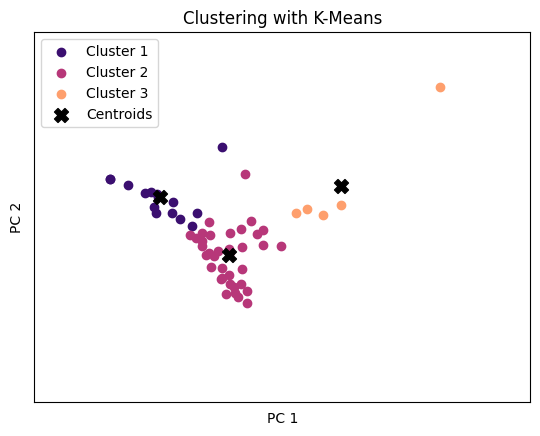

In [530]:
# Clustering - KMeans

from sklearn.cluster import KMeans

data = reduced_data

NO_OF_CLUSTERS = 3
# Create a KMeans instance with 3 clusters
kmeans = KMeans(n_clusters=NO_OF_CLUSTERS, random_state=42)

# Fit the KMeans model to the data and predict the cluster labels
cluster_labels = kmeans.fit_predict(data)

# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

colors=plt.cm.magma(np.linspace(0.2, 0.8, num=3))

for c in range(NO_OF_CLUSTERS): 
    # Separate the data points by cluster
    cluster_data = data[cluster_labels == c]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {c+1}', color=colors[c])

# Plot the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='black', label='Centroids')

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.xlim(-6, 10)
plt.ylim(-5, 6)
plt.title('Clustering with K-Means')
plt.legend()
plt.show()

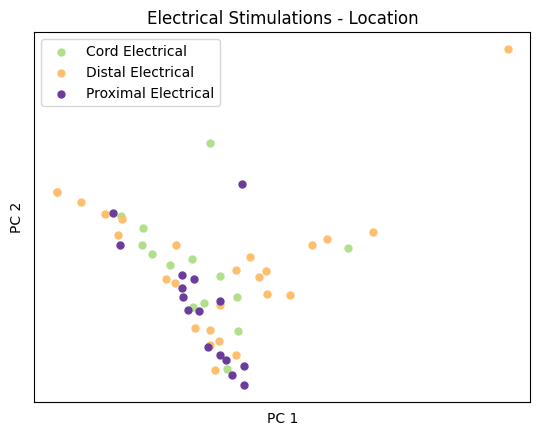

In [508]:
class_type = 'labels'

class_list = driver.stim_class_list
no_of_points = len(class_list)
colors = plt.cm.Paired(np.linspace(0.2, 0.8, num=no_of_points))

for c in range(no_of_points):
    indices = df_features.query(f'{class_type} == {c}').index
    class_data = reduced_data[indices]
    plt.scatter(class_data[:, 0], class_data[:, 1],
                color=colors[c], label=class_list[c], s=25)
            
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.title(f'Electrical Stimulations - Location')
plt.show()

In [ ]:
class DataManager:
    def __init__(self, keys=[]):
        self.data = {key: [] for key in keys}
    
    def _print_key_error(self, key):
        print(f"Key '{key}' does not exist in the data manager.")

    def add_nan(self, key, shape):
        data_ = self.data[key]
        pop_count = 0
        while len(data_) > 0 and data_[-1] is None:
            data_.pop()
            pop_count += 1
        while pop_count > 0:
            data_.append(np.full(shape, np.nan))
            pop_count -= 1

    def add(self, key, value):
        if key in self.data:
            if value is not None:
                self.add_nan(key, value.shape)
            self.data[key].append(value)
        else:
            self._print_key_error(key)

    def to_numpy(self):
        for key in self.data:
            data_ = self.data[key]
            if len(data_) == 0 or data_[0] is None:
                self.data[key] = None
                return
            self.add_nan(key, data_[0].shape)
            self.data[key] = np.array(data_)

    def save(self, dir):
        for key in self.data:
            np.save(f'{dir}/{key}.npy', self.data.get(key))

    def load(self, dir, keys):
        if keys is None:
            keys = self.data.keys
        for key in keys:
            self.data[key] = np.load(f'{dir}/{key}.npy')
        return self.data

    def remove(self, key):
        if key in self.data:
            del self.data[key]
        else:
            self._print_key_error(key)

    def get(self, key):
        if key in self.data:
            return self.data[key]
        else:
            self._print_key_error(key)
            return None

In [ ]:
class DLCManager:
    def __init__(self, 
            model_path,
            processor=Processor(),
            pcutoff=0.2,
            resize=1):
        
        self.model = DLCLive(
            model_path=model_path,
            processor=processor,
            pcutoff=pcutoff,
            # display=True,
            resize=resize)
        self.frame = None
        self.is_first_frame = None
        self.dm = DataManager()

    def init_data(self, feature_keys):
        self.dm = DataManager(feature_keys)
        self.prev_pose_xy = None
        
    def update_frame(self, frame, is_first_frame):
        self.frame = frame
        self.is_first_frame = is_first_frame
        
    def detect_pose_helper(self):
        if self.is_first_frame:
            pose = self.model.init_inference(self.frame)
        else:
            pose = self.model.get_pose(self.frame)
        return pose
        
    def detect_pose(self):
        curr_pose = self.detect_pose_helper()
        
        curr_pose_xy, curr_pose_p = curr_pose[:, :-1], curr_pose[:, -1]
        if self.prev_pose_xy is None:
            self.prev_pose_xy = curr_pose_xy

        pose = np.stack([self.prev_pose_xy, curr_pose_xy])
        feature_angles_item, pose_speed_item = extract_pose_features(pose)

        self.dm.add('xy', curr_pose_xy)
        self.dm.add('p', curr_pose_p)
        self.dm.add('angles', feature_angles_item)
        self.dm.add('speed', pose_speed_item)

        self.prev_pose_xy = curr_pose_xy

    def save_data(self, dir):
        self.dm.to_numpy()
        self.dm.save(dir)

    def load_data(self, dir, feature_keys):
        return self.dm.load(dir, feature_keys)

100%|██████████| 56/56 [00:07<00:00,  7.87it/s]


poor_pose: 0
file_missing: 0


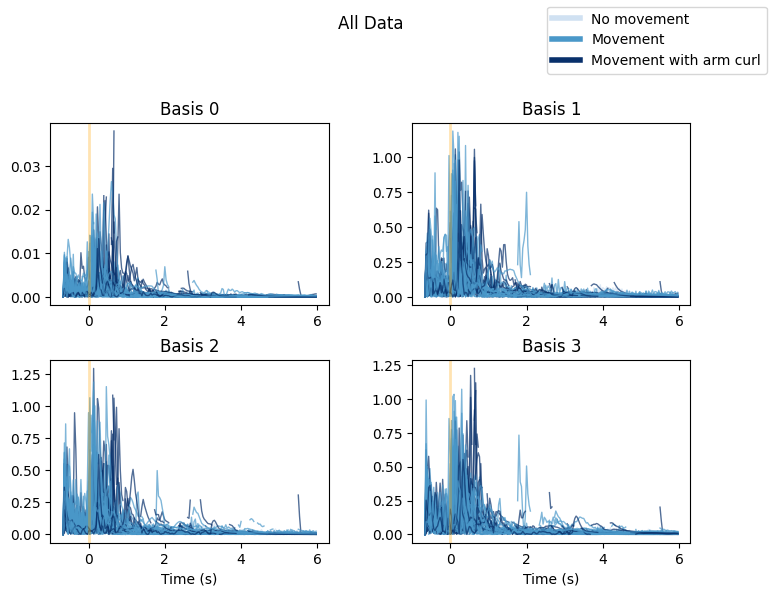

In [498]:
# # Plot 2: all experiments separately with basis as separate plots -- movement

# stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
# stim_count = len(stim_class_list)

# num_figures = PROSVD_K
# num_rows = int(np.ceil(np.sqrt(num_figures)))
# num_cols = num_figures//num_rows

# movement_types = [
#     "No movement",
#     "Movement",
#     "Movement with arm curl"
# ]

# fig_all = []
# axs_all = []

# num_lines = 3 # for 3 movement classes
# colors = plt.cm.Blues(np.linspace(0.2, 1, num=num_lines))

# titles = [
#     "n-Norm of t-Diff of Q",
# ]

# tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

# err_log = {
#     'poor_pose': [],
#     'file_missing': []
# }

# for r in range(1): 
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6), gridspec_kw={'top': 0.8})
#     fig_all.append(fig)
#     axs_all.append(axs)

# feature_all = []
# label_all = []

# for video_idx in tqdm(range(len(filenames))):
#     video_filename = filenames[video_idx]

#     figs_dir = get_fig_dir(video_filename)
#     data_dir = get_data_dir(video_filename)

#     try:
#         Q_full = np.load(f'{data_dir}/Q.npy')
#     except ValueError:
#         err_log['poor_pose'].append(video_filename)
#         continue
#     except FileNotFoundError:
#         err_log['file_missing'].append(video_filename)
#         continue
#     except:
#         raise("Uncaught exception")

#     total_frames = Q_full.shape[0]

#     row = None
#     if IS_METADATA_PRESENT:
#         row = files_info.iloc[video_idx]

#     stim_class = row["Stimulation Class"]

#     metadata = load_metadata(video_filename, total_frames, row, fps, init_frame)

#     Q_diff = np.diff(Q_full, axis=0)
#     Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
#     Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

#     move_class = int(row['Classification'])
#     stim_idx = stim_class_list.index(stim_class)

#     feature_all.append(Q_norm_diff[:, 1])
#     label_all.append(stim_idx)

#     ## PLOTTING ##

#     data = [
#         Q_norm_diff,
#     ]

#     start_f = metadata['start']['f']
#     end_f = metadata['end']['f']

#     for r in range(len(titles)):
#         for i in range(num_rows):
#             for j in range(num_cols):
#                 k = j + i*num_rows
#                 data_ = data[r][:, k]
#                 # data_ = smooth_data(data_, kernel_size = 3)
#                 axs_all[m][i, j].plot(tx, data_, c=colors[move_class], alpha=0.7, label=move_class, linewidth=1)
#                 axs_all[m][i, j].set_title(f'Basis {k}')

#     for x in data:
#         del x

#     del Q_full

# feature_all = np.array(feature_all)
# label_all = np.array(label_all)
            
    
# # legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=movement_types[i]) for i in range(3)]

# # ylims = [1e-2, 4e-1, 4e-1, 4e-1]
# # for r in range(len(titles)):
# #     fig_all[r].legend(handles=legend_elements, loc='upper right')
# #     fig_all[r].subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

# #     for i in range(num_rows):
# #         for j in range(num_cols):
# #             # axs_all[r][i].set_ylim(0, ylims[r])
# #             axs_all[r][i, j].axvline(x=0, color='orange', linewidth=2, alpha=0.3)
# #             axs_all[r][-1, j].set_xlabel("Time (s)")

# #     fig_all[r].suptitle(f'All Data')

# #     figs_dir_full = f'{figs_dir}/{titles[r]}'
# #     os.makedirs(figs_dir_full, exist_ok=True)
# #     fig_all[r].savefig(f'{figs_dir_full}/all_data.png', facecolor='white')

# # for key, items in err_log.items():
# #     print(f"{key}: {len(items)}")
# #     for item in items:
# #         print(f"\t{item}")

100%|██████████| 56/56 [00:06<00:00,  8.08it/s]


poor_pose: 0
file_missing: 0


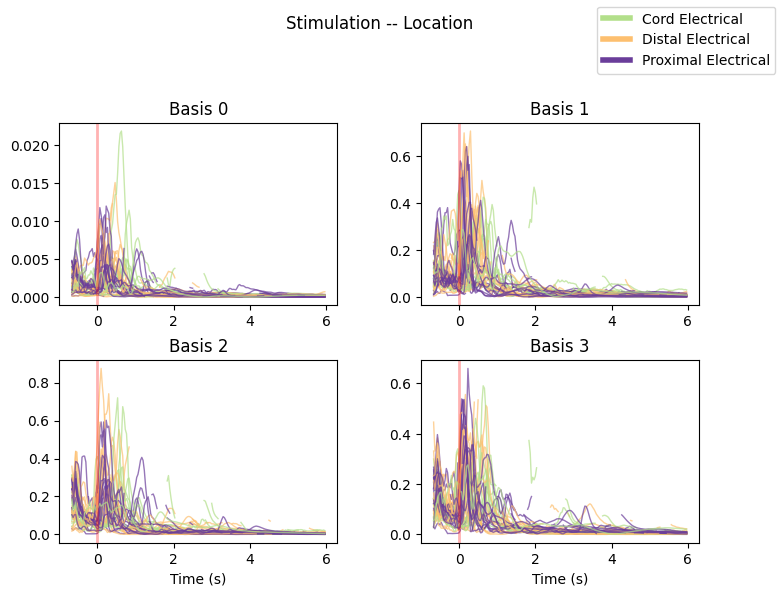

In [506]:
# # Plot 2b: all experiments separately with basis as separate plots -- stim location

stim_class_list = sorted(files_info['Stimulation Class'].unique().tolist())
stim_count = len(stim_class_list)

num_figures = PROSVD_K
num_rows = int(np.ceil(np.sqrt(num_figures)))
num_cols = num_figures//num_rows

movement_types = [
    "No movement",
    "Movement",
    "Movement with arm curl"
]

fig_all = []
axs_all = []

num_lines = 3 # for 3 movement classes
colors = plt.cm.Paired(np.linspace(0.2, 0.8, num=num_lines))

titles = [
    "n-Norm of t-Diff of Q",
]

tx = np.arange(init_frame + TIME_MARGIN[0], TIME_MARGIN[1])/fps

err_log = {
    'poor_pose': [],
    'file_missing': []
}

for r in range(1): 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6), gridspec_kw={'top': 0.8})
    fig_all.append(fig)
    axs_all.append(axs)

feature_all = []
label_all = []

for video_idx in tqdm(range(len(filenames))):
    video_filename = filenames[video_idx]

    figs_dir = get_fig_dir(video_filename)
    data_dir = get_data_dir(video_filename)

    try:
        Q_full = np.load(f'{data_dir}/Q.npy')
    except ValueError:
        err_log['poor_pose'].append(video_filename)
        continue
    except FileNotFoundError:
        err_log['file_missing'].append(video_filename)
        continue
    except:
        raise("Uncaught exception")

    total_frames = Q_full.shape[0]

    row = None
    if IS_METADATA_PRESENT:
        row = files_info.iloc[video_idx]

    stim_class = row["Stimulation Class"]

    metadata = load_metadata(video_filename, total_frames, row, fps, init_frame)

    Q_diff = np.diff(Q_full, axis=0)
    Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
    Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

    move_class = int(row['Classification'])
    stim_idx = stim_class_list.index(stim_class)

    feature_all.append(Q_norm_diff[:, 1])
    label_all.append(stim_idx)

    ## PLOTTING ##

    data = [
        Q_norm_diff,
    ]

    start_f = metadata['start']['f']
    end_f = metadata['end']['f']

    for r in range(len(titles)):
        for i in range(num_rows):
            for j in range(num_cols):
                k = j + i*num_rows
                data_ = data[r][:, k]
                # data_ = fill_nan_linear_interpolation_axis(data_, axis=0)
                data_ = smooth_data(data_, kernel_size = 5)
                axs_all[m][i, j].plot(tx, data_, c=colors[stim_idx], alpha=0.7, label=stim_idx, linewidth=1)
                axs_all[m][i, j].set_title(f'Basis {k}')

    for x in data:
        del x

    del Q_full

feature_all = np.array(feature_all)
label_all = np.array(label_all)

legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=stim_class_list[i]) for i in range(3)]

ylims = [1e-2, 4e-1, 4e-1, 4e-1]
for r in range(len(titles)):
    fig_all[r].legend(handles=legend_elements, loc='upper right')
    fig_all[r].subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

    for i in range(num_rows):
        for j in range(num_cols):
            # axs_all[r][i].set_ylim(0, ylims[r])
            axs_all[r][i, j].axvline(x=0, color='red', linewidth=2, alpha=0.3)
            axs_all[r][-1, j].set_xlabel("Time (s)")

    fig_all[r].suptitle(f'Stimulation -- Location')

    figs_dir_full = f'{figs_dir}/{titles[r]}'
    os.makedirs(figs_dir_full, exist_ok=True)
    fig_all[r].savefig(f'{figs_dir_full}/all_data_stim.png', facecolor='white')

for key, items in err_log.items():
    print(f"{key}: {len(items)}")
    for item in items:
        print(f"\t{item}")

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM


num_classes = 3

# Load and preprocess the data
with open(f'data/pro_features.pkl', 'rb') as f:
    df_features = pickle.load(f)
X = np.stack(df_features['features'].values, axis=-1)
X = X.reshape(-1, X.shape[-1]).T
# linear interpolation to fill nan values
X = fill_nan_linear_interpolation_axis(X, axis=1)

y = df_features['labels'].values.astype(int)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=300, batch_size=4, verbose=0);


In [ ]:
%matplotlib inline
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Perform predictions on the test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

class_names = le.classes_

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

# Visualize the confusion matrix as a heatmap
first_words = [string.split()[0] for string in stim_class_list]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=first_words, yticklabels=first_words)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Stimulation point of contact - using proSVD')
plt.show()
